# GSE26320 summary

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import tempfile
from itertools import product

import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [3]:
# Load frip datasets
GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320')
! mkdir -p {GSE26320_PATH_HG38}/pics

GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
GSE26320_MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
# GSE26320_MODIFICATIONS = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1']
GSE26320_REPS = ['rep1', 'rep2']

In [4]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

In [5]:
def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        mod = next((m for m in GSE26320_MODIFICATIONS if m in f), None)
        rep = next((r for r in GSE26320_REPS if r in f), None)
        if fdr and cell and rep and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (peaks_path, mod, cell, rep, fdr, ps, avls)
    return df_fdr

In [6]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), 'summary-FDR', ['0.01'])
# df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), '.scoreisland', ['0.01'])
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'span'), '.peak', ['0.05'])
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'SPAN']
df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 85


,file,modification,cell,replicate,fdr,peaks,avlength,tool
59,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K4me1,H1,rep1,0.1,54953,908.486707,MACS2 broad
70,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K27me3,H1,rep1,0.01,10605,4148.570957,SICER
52,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K36me3,HSMM,rep1,0.05,57821,10182.139102,SPAN
72,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K4me1,HSMM,rep1,0.05,68255,1533.662735,SPAN
38,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K36me3,Huvec,rep2,0.01,31178,8367.003079,SICER


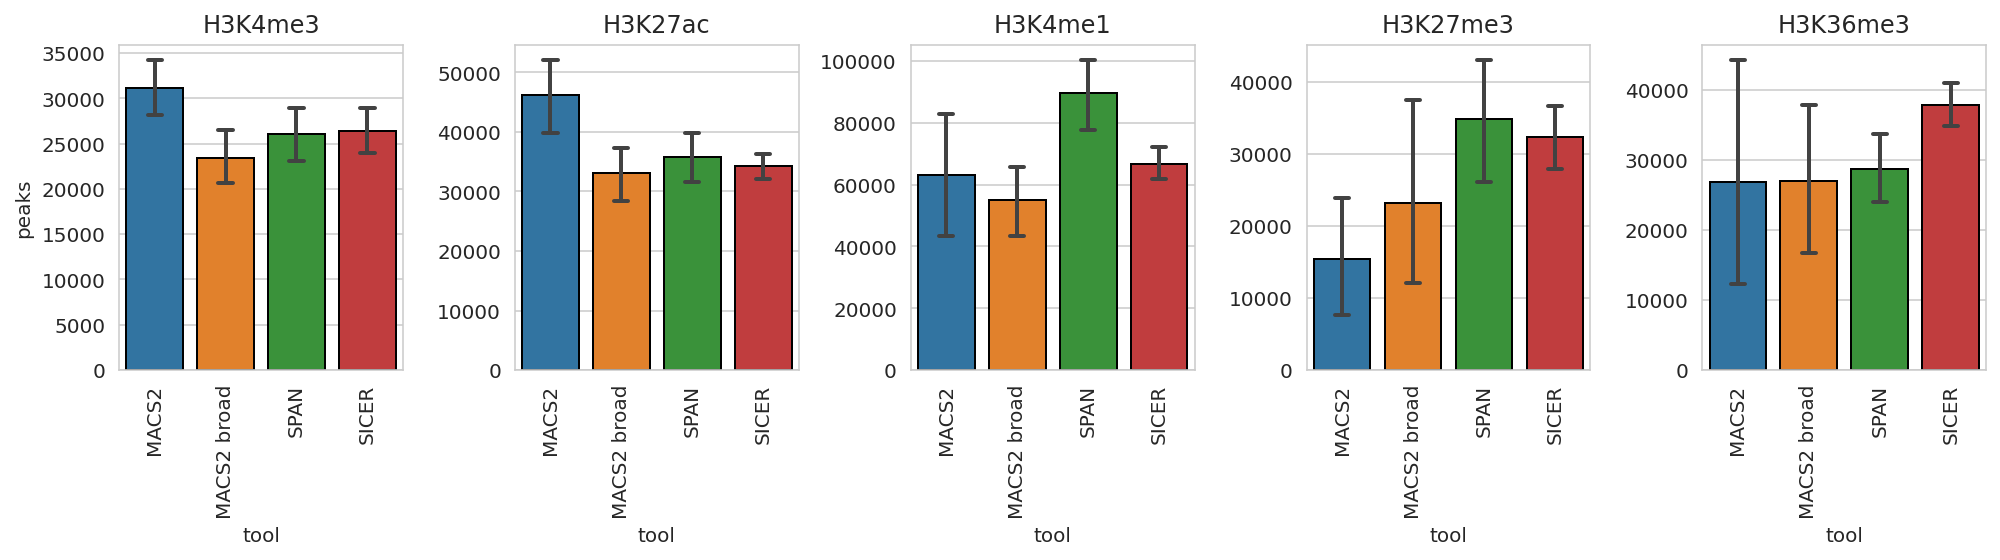

In [7]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(GSE26320_MODIFICATIONS):
    ax = axs[i]
    g_results = sns.barplot(data=df_fdr_peaks[df_fdr_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [10]:
diff_bench_df = pd.DataFrame(
    columns=['modification', 'cell', 'replicate', 'name', 'peaks'],
    dtype=object
)

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

for m, c, r in tqdm(list(product(GSE26320_MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS))):
    print(m, c, r)
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') &
                     (df_fdr_peaks['modification'] == m) &
                     (df_fdr_peaks['cell'] == c) &
                     (df_fdr_peaks['replicate'] == r)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    # Processing single tools information
    for tool in TOOLS:
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == m) &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        diff_bench_df.loc[len(diff_bench_df)] = (m, c, r, tool, lines(peaks_file))
        if tool == 'SPAN':
            continue
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            diff_bench_df.loc[len(diff_bench_df)] = (m, c, r, name, lines(tf))

display(diff_bench_df.sample(5))

  0%|          | 0/90 [00:00<?, ?it/s]

H3K4me3 GM12878 rep1
H3K4me3 GM12878 rep2
H3K4me3 HMEC rep1
H3K4me3 HMEC rep2
H3K4me3 HSMM rep1
H3K4me3 HSMM rep2
H3K4me3 K562 rep1
H3K4me3 K562 rep2
H3K4me3 NHEK rep1
H3K4me3 NHEK rep2
H3K4me3 NHLF rep1
H3K4me3 NHLF rep2
H3K4me3 H1 rep1
H3K4me3 H1 rep2
H3K4me3 Huvec rep1
H3K4me3 Huvec rep2
H3K4me3 HepG2 rep1
H3K4me3 HepG2 rep2
H3K27ac GM12878 rep1
H3K27ac GM12878 rep2
H3K27ac HMEC rep1
H3K27ac HMEC rep2
H3K27ac HSMM rep1
H3K27ac HSMM rep2
H3K27ac K562 rep1
H3K27ac K562 rep2
H3K27ac NHEK rep1
H3K27ac NHEK rep2
H3K27ac NHLF rep1
H3K27ac NHLF rep2
H3K27ac H1 rep1
H3K27ac H1 rep2
H3K27ac Huvec rep1
H3K27ac Huvec rep2
H3K27ac HepG2 rep1
H3K27ac HepG2 rep2
H3K4me1 GM12878 rep1
H3K4me1 GM12878 rep2
H3K4me1 HMEC rep1
H3K4me1 HMEC rep2
H3K4me1 HSMM rep1
H3K4me1 HSMM rep2
H3K4me1 K562 rep1
H3K4me1 K562 rep2
H3K4me1 NHEK rep1
H3K4me1 NHEK rep2
H3K4me1 NHLF rep1
H3K4me1 NHLF rep2
H3K4me1 H1 rep1
H3K4me1 H1 rep2
H3K4me1 Huvec rep1
H3K4me1 Huvec rep2
H3K4me1 HepG2 rep1
H3K4me1 HepG2 rep2
H3K27me3 G

,modification,cell,replicate,name,peaks
179,H3K27ac,GM12878,rep2,SPAN,31050
432,H3K4me1,NHLF,rep1,MACS2 - SPAN,0
320,H3K27ac,HepG2,rep2,MACS2,26021
532,H3K27me3,HMEC,rep2,MACS2 - SPAN,1064
467,H3K4me1,H1,rep2,SPAN - SICER,38574


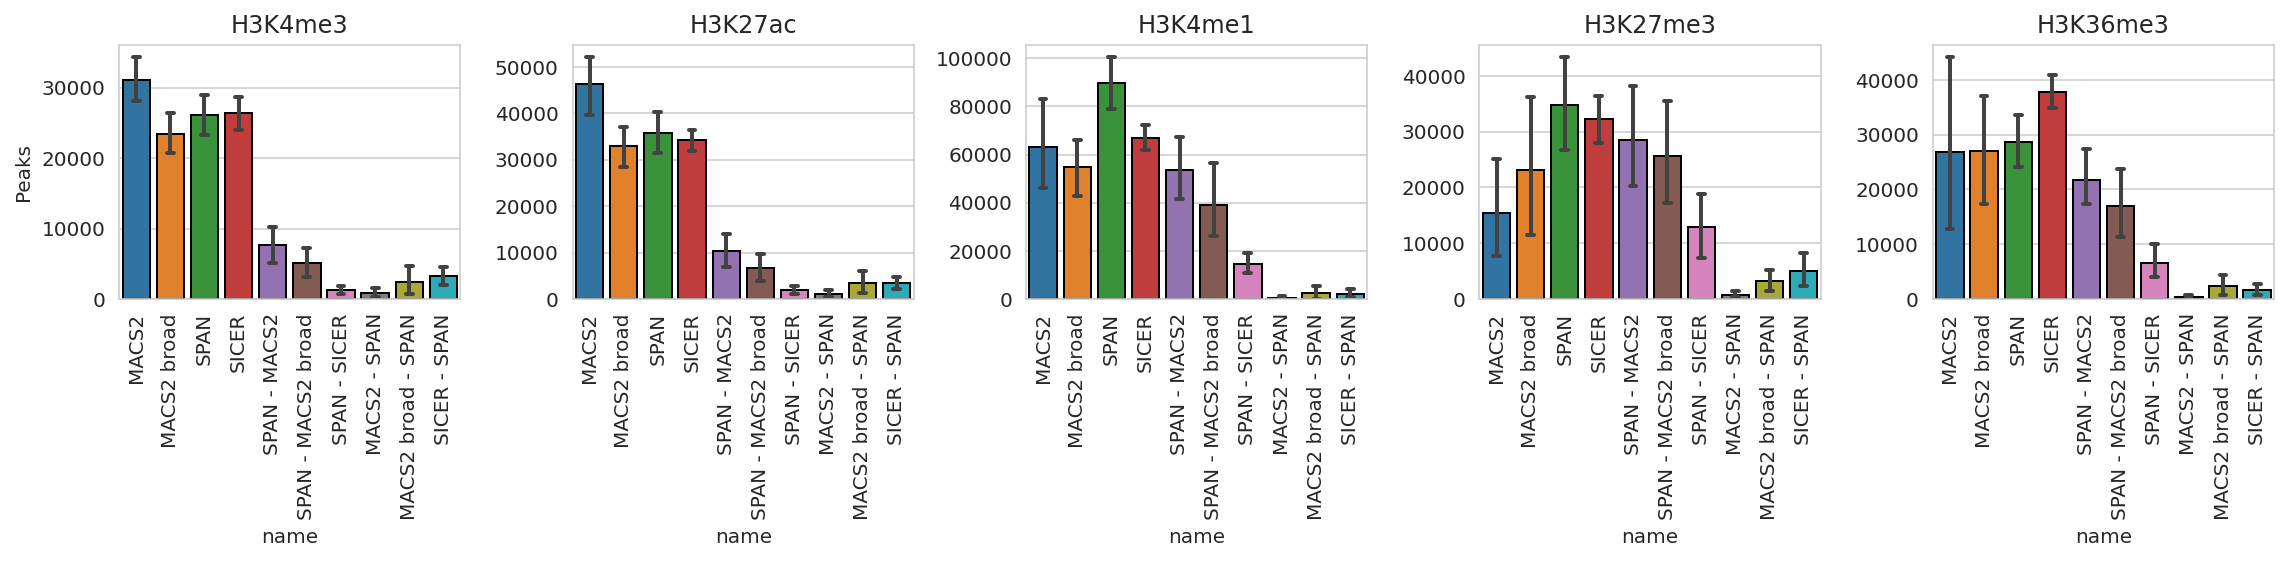

In [17]:
plt.figure(figsize=(16, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(GSE26320_MODIFICATIONS):
    ax = axs[i]
    g_results = sns.barplot(data=diff_bench_df[diff_bench_df['modification'] == m], x='name', y='peaks', 
                            ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                         'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                         'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                         ]
                            )
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('Peaks')
plt.tight_layout()
plt.savefig(GSE26320_PATH_HG38 + f'/pics/peaks_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Compute BAM coverage

In [29]:
def load_bams(path):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'mapped_reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in GSE26320_CELLS if c in f), None)
        rep = next((r for r in GSE26320_REPS if r in f), None)
        mod = next((m for m in GSE26320_MODIFICATIONS + ['Input'] if m in f), None)
        if cell and rep and mod:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams

bams_df = load_bams(GSE26320_PATH_HG38 + '/bams')
bams_df

  0%|          | 0/206 [00:00<?, ?it/s]

,bam_file,modification,cell,replicate,mapped_reads
0,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K36me3,NHLF,rep1,14385159
1,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K36me3,NHEK,rep2,7569713
2,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K27ac,NHEK,rep1,9377615
3,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K27me3,HSMM,rep2,8356060
4,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me1,K562,rep2,7777248
...,...,...,...,...,...
98,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Input,GM12878,rep1,5699825
99,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me3,NHEK,rep1,8169225
100,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Input,H1,rep2,2998695
101,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Input,HSMM,rep2,7218491


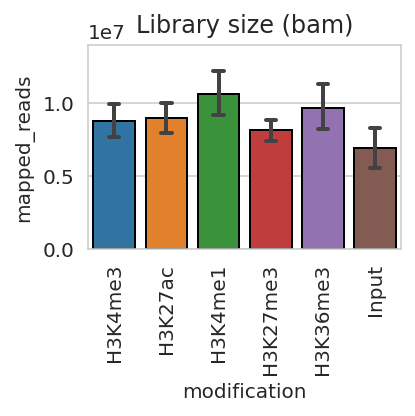

In [35]:
plt.figure(figsize=(3, 3))
ax = plt.axes()
g_results = sns.barplot(data=bams_df, x='modification', y='mapped_reads', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        order=GSE26320_MODIFICATIONS + ['Input'])
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('Library size (bam)')
ax.set_ylim(0, 1.4e7)
plt.tight_layout()
plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

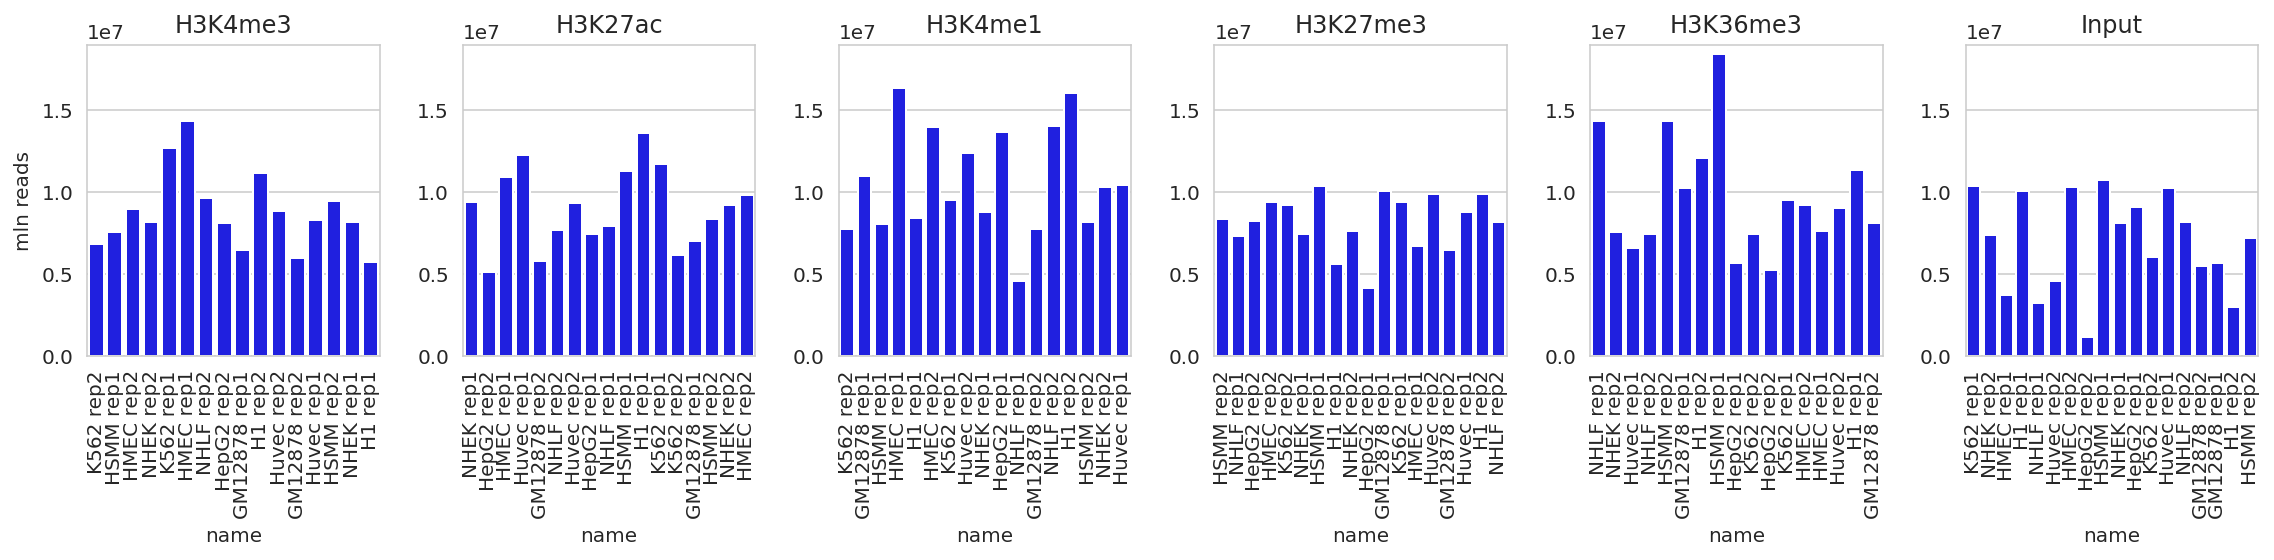

In [40]:
bams_df['name'] = bams_df['cell'] + ' ' + bams_df['replicate']

plt.figure(figsize=(16, 4))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'Input']):
    ax = axs[i]
    g_results = sns.barplot(data=bams_df[bams_df['modification'] == m], x='name', y='mapped_reads', ax=ax, color='blue')
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('mln reads')
    ax.set_ylim(0, 1.9e7)
plt.tight_layout()
plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# SPAN signal to noise and frip estimations

In [6]:
def load_span_logs(logs_path):
    df_span = pd.DataFrame(
        columns=['log_file', 'modification', 'cell', 'replicate', 'signal-to-noise', 'frip'], dtype=object)
    for f in tqdm(os.listdir(logs_path)):
        if not f.endswith('.log'):
            continue
        cell = next((c for c in GSE26320_CELLS if c in f), None)
        rep = next((r for r in GSE26320_REPS if r in f), None)
        mod = next((m for m in GSE26320_MODIFICATIONS if m in f), None)
        if cell and rep and mod:
            file = os.path.join(logs_path, f)
            out = ! cat {file} | grep "Signal to noise:"
            sn = float(out[0].replace('Signal to noise: ', ''))
            out = ! cat {file} | grep "FRIP:"
            frip = float(out[0].replace('FRIP: ', ''))
            df_span.loc[len(df_span)] = (file, mod, cell, rep, sn, frip)
    return df_span

df_span = load_span_logs(GSE26320_PATH_HG38 + '/logs/span')
df_span

  0%|          | 0/85 [00:00<?, ?it/s]

,log_file,modification,cell,replicate,signal-to-noise,frip
0,/home/jetbrains/data/2023_GSE26320/logs/span/G...,H3K4me1,HSMM,rep2,6.993467,0.536627
1,/home/jetbrains/data/2023_GSE26320/logs/span/G...,H3K4me1,NHEK,rep1,8.420408,0.557631
2,/home/jetbrains/data/2023_GSE26320/logs/span/G...,H3K4me1,NHEK,rep2,10.776626,0.629875
3,/home/jetbrains/data/2023_GSE26320/logs/span/G...,H3K36me3,HMEC,rep1,2.218266,0.328929
4,/home/jetbrains/data/2023_GSE26320/logs/span/G...,H3K27me3,K562,rep1,0.906632,0.237057
...,...,...,...,...,...,...
80,/home/jetbrains/data/2023_GSE26320/logs/span/G...,H3K36me3,GM12878,rep2,4.255306,0.567496
81,/home/jetbrains/data/2023_GSE26320/logs/span/G...,H3K4me3,HSMM,rep2,38.131073,0.713730
82,/home/jetbrains/data/2023_GSE26320/logs/span/G...,H3K36me3,HSMM,rep2,5.978465,0.665963
83,/home/jetbrains/data/2023_GSE26320/logs/span/G...,H3K4me1,HepG2,rep1,7.701030,0.519639


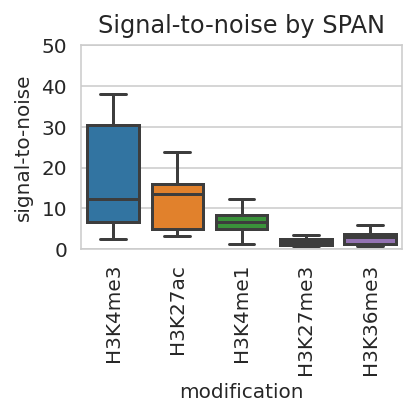

In [7]:
plt.figure(figsize=(3, 3))
g_results = sns.boxplot(data=df_span,
                        x='modification', y='signal-to-noise',
                        order=GSE26320_MODIFICATIONS,
                        showfliers=False)
ax = g_results.axes
ax.set_title('Signal-to-noise by SPAN')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim(0, 50)
plt.tight_layout()
plt.savefig(GSE26320_PATH_HG38 + f'/pics/signal_to_noise_span_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

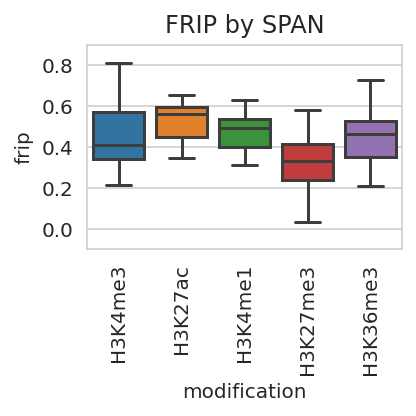

In [8]:
plt.figure(figsize=(3, 3))
g_results = sns.boxplot(data=df_span,
                        x='modification', y='frip',
                        order=GSE26320_MODIFICATIONS,
                        showfliers=False)
ax = g_results.axes
ax.set_title('FRIP by SPAN')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim(-0.1, 0.9)
plt.tight_layout()
plt.savefig(GSE26320_PATH_HG38 + f'/pics/frip_span_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# FRIP datatables

In [9]:
ts = []
for m in GSE26320_MODIFICATIONS:
    t = pd.read_csv(f'{GSE26320_PATH_HG38}/pics/{m}_frip.csv.gz', compression='gzip')
    t['modification'] = m
    ts.append(t)

frip_df_all = pd.concat(ts).reset_index(drop=True)
del t
del ts
frip_df_all.sample(5)

,cell,replicate,bw_file,tool,peaks_file,peaks,length,reads_in_peaks,all_reads,control_reads_in_peaks,control_all_reads,frip,peaks_rpkm,peaks_background_log2fc,peaks_control_log2fc,modification
223,NHEK,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64645...,MACS2 broad,/tmp/tmp0e2o3uff,58290,37525393,1.311536e+07,7.959542e+07,9.099350e+05,8.302540e+07,0.164775,4.391036,4.003495,3.910218,H3K27me3
31,K562,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64644...,SICER,/tmp/tmp1oxkhafp,29338,88157062,3.878969e+07,9.184109e+07,4.928987e+06,9.736366e+07,0.422357,4.790956,4.637087,3.060554,H3K4me3
260,HSMM,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64639...,SICER,/tmp/tmp1_m67v0c,45580,363253620,5.059425e+07,8.205425e+07,1.042489e+07,5.872033e+07,0.616595,1.697423,3.592680,1.796224,H3K36me3
169,NHEK,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64646...,SICER,/tmp/tmphsvypxwx,70847,235098953,5.625105e+07,8.309886e+07,1.035899e+07,8.302540e+07,0.676917,2.879286,4.668310,2.439721,H3K4me1
42,NHLF,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64648...,MACS2,/tmp/tmpnvzbk48c,31110,32264182,4.435115e+07,7.789808e+07,1.237673e+06,8.171395e+07,0.569348,17.646456,6.968369,5.232264,H3K4me3


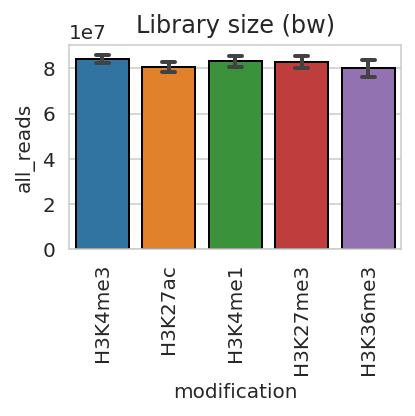

In [10]:
plt.figure(figsize=(3, 3))
ax = plt.axes()
g_results = sns.barplot(data=frip_df_all, x='modification', y='all_reads', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        order=GSE26320_MODIFICATIONS)
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('Library size (bw)')
plt.tight_layout()
plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

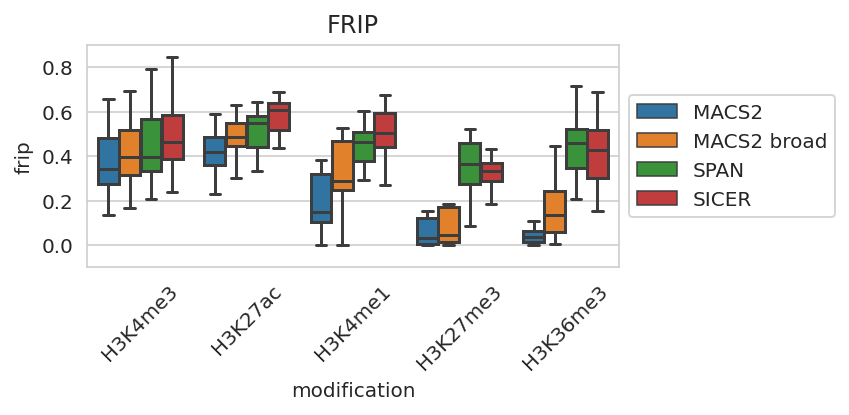

In [11]:
plt.figure(figsize=(6, 3))
g_results = sns.boxplot(data=frip_df_all,
                        x='modification', y='frip', hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False
                        # errorbar='se', marker='o', markersize=8
                        )
ax = g_results.axes
ax.set_title('FRIP')
ax.xaxis.set_tick_params(rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-0.1, 0.9)
plt.tight_layout()
plt.savefig(GSE26320_PATH_HG38 + f'/pics/frip_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

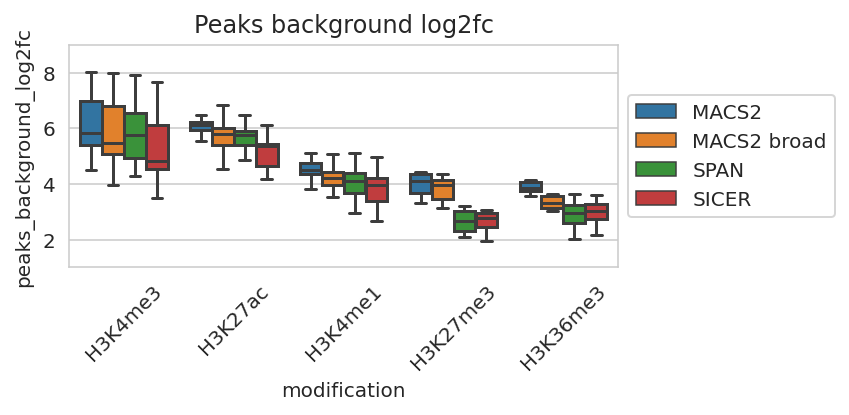

In [12]:
plt.figure(figsize=(6, 3))
g_results = sns.boxplot(data=frip_df_all,
                        x='modification', y='peaks_background_log2fc', hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False
                        # errorbar='se', marker='o', markersize=8
                        )
ax = g_results.axes
ax.set_title('Peaks background log2fc')
ax.xaxis.set_tick_params(rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(1, 9)
plt.tight_layout()
plt.savefig(GSE26320_PATH_HG38 + f'/pics/peaks_background_log2fc_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

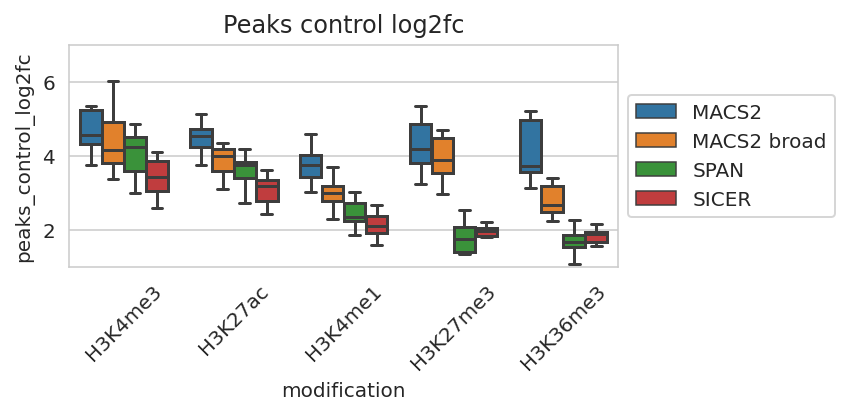

In [13]:
plt.figure(figsize=(6, 3))
g_results = sns.boxplot(data=frip_df_all,
                        x='modification', y='peaks_control_log2fc', hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False
                        # errorbar='se', marker='o', markersize=8
                        )
ax = g_results.axes
ax.set_title('Peaks control log2fc')
ax.xaxis.set_tick_params(rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(1, 7)
plt.tight_layout()
plt.savefig(GSE26320_PATH_HG38 + f'/pics/peaks_control_log2fc_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [14]:
df_span.rename({'frip': 'span-frip'}, axis=1, inplace=True)
t = frip_df_all[frip_df_all['tool'] == 'SPAN'].copy()
t = pd.merge(left=df_span, right=t, left_on=['cell', 'modification'], right_on=['cell', 'modification'])
t.sample(5)

,log_file,modification,cell,replicate_x,signal-to-noise,span-frip,replicate_y,bw_file,tool,peaks_file,peaks,length,reads_in_peaks,all_reads,control_reads_in_peaks,control_all_reads,frip,peaks_rpkm,peaks_background_log2fc,peaks_control_log2fc
92,/home/jetbrains/data/2023_GSE26320/logs/span/G...,H3K4me1,K562,rep1,2.245312,0.506391,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64644...,SPAN,/tmp/tmposc3fite,71577,134743204,3.993626e+07,8.166659e+07,9.103278e+06,9.641159e+07,0.489016,3.629244,4.390765,2.372702
148,/home/jetbrains/data/2023_GSE26320/logs/span/G...,H3K4me1,HepG2,rep1,7.701030,0.519639,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64636...,SPAN,/tmp/tmpuvteirgw,88821,168825801,3.719414e+07,7.464744e+07,7.631472e+06,8.086781e+07,0.498264,2.951351,4.102077,2.400515
52,/home/jetbrains/data/2023_GSE26320/logs/span/G...,H3K27ac,NHEK,rep1,17.702584,0.645090,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64645...,SPAN,/tmp/tmpcpk_fobz,43724,73788102,4.928980e+07,7.978378e+07,3.572266e+06,8.302540e+07,0.617792,8.372517,6.045150,3.843835
96,/home/jetbrains/data/2023_GSE26320/logs/span/G...,H3K27ac,K562,rep2,3.314389,0.452250,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64643...,SPAN,/tmp/tmp8ub_avy4,26221,44725752,3.320050e+07,7.938239e+07,3.479086e+06,9.663252e+07,0.418235,9.351103,5.612388,3.538115
103,/home/jetbrains/data/2023_GSE26320/logs/span/G...,H3K4me3,HMEC,rep2,6.272793,0.240207,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64638...,SPAN,/tmp/tmpdes6m1v9,13275,19775683,1.894196e+07,8.093116e+07,6.736599e+05,8.356778e+07,0.234050,11.835258,5.567236,4.859673


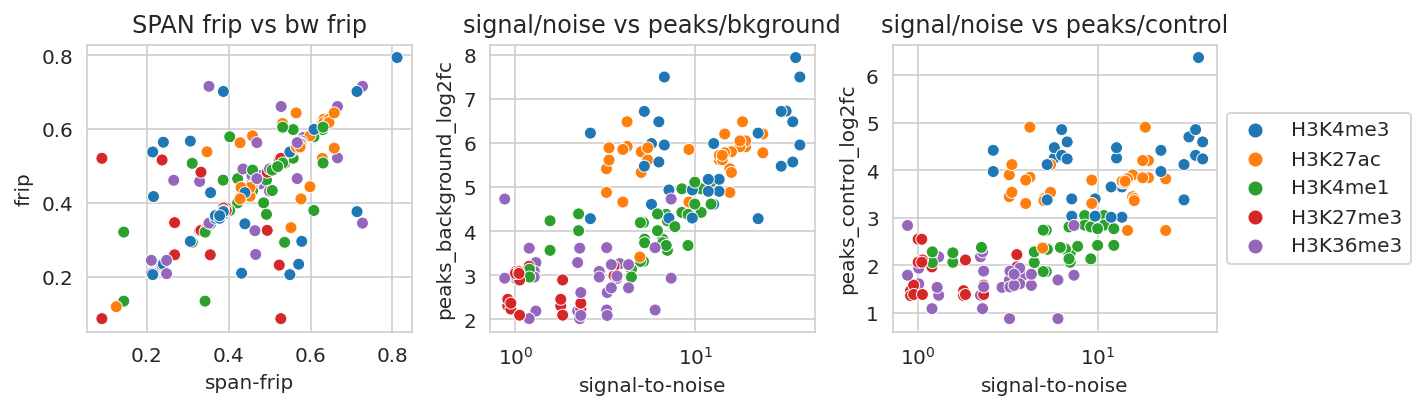

In [15]:
plt.figure(figsize=(10, 3))
axes = [plt.subplot(1, 3, i+1) for i in range(3)]

ax = axes[0]
sns.scatterplot(t, x='span-frip', y='frip',
                hue='modification', hue_order=GSE26320_MODIFICATIONS, ax=ax)
ax.set_title('SPAN frip vs bw frip')
ax.legend().set_visible(False)

ax = axes[1]
sns.scatterplot(t, x='signal-to-noise', y='peaks_background_log2fc',
                hue='modification', hue_order=GSE26320_MODIFICATIONS, ax=ax)
ax.set_xscale('log')
ax.set_title('signal/noise vs peaks/bkground')
ax.legend().set_visible(False)

ax = axes[2]
sns.scatterplot(t, x='signal-to-noise', y='peaks_control_log2fc',
                hue='modification', hue_order=GSE26320_MODIFICATIONS, ax=ax)
ax.set_xscale('log')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('signal/noise vs peaks/control')

plt.tight_layout()
plt.savefig(GSE26320_PATH_HG38 + f'/pics/span_vs_bw_log2fc_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Noise

In [10]:
GSE26320_NOISE_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320_noise')
! mkdir -p {GSE26320_NOISE_PATH_HG38}/pics

# Summary Jacard

In [12]:
# Load immune bad quality dataset
mln_bench_df_all = pd.concat([
    pd.read_csv(GSE26320_NOISE_PATH_HG38 + f'/{m}_mln_bench_df.csv.gz', compression='gzip')
    for m in ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
]).reset_index(drop=True)
mln_bench_df_all.sample(5)

,cell,replicate,name,full_peaks,full_peaks_len,quality,mln_peaks,mln_peaks_len,full_overlap,mln_overlap,overlap_len,precision,sensitivity,f1,precision_len,sensitivity_len,f1_len,jaccard,q,modification
306,K562,rep2,MACS2,13503,2972003,2,0,0,0,0,0,0.000000,0.000000,1.000000e-10,0.000000,0.000000,1.000000e-10,0.000000,2,H3K27me3
284,Huvec,rep2,SICER,70741,175789459,7,41592,171792808,45700,41546,140407656,0.998894,0.646019,7.846059e-01,0.817308,0.798726,8.079104e-01,0.677726,0,H3K4me1
23,GM12878,rep2,MACS2 broad,27319,57626660,1,552,221010,537,552,221010,1.000000,0.019657,3.855543e-02,1.000000,0.003835,7.641103e-03,0.003835,3,H3K4me3
100,GM12878,rep1,MACS2 broad,31476,65449208,7,33179,37521913,22421,33179,37519967,1.000000,0.712320,8.319944e-01,0.999948,0.573268,7.287474e-01,0.573251,0,H3K27ac
79,Huvec,rep1,SICER,24595,74793205,1,9506,20569494,9234,9506,19738486,1.000000,0.375442,5.459221e-01,0.959600,0.263907,4.139666e-01,0.261007,3,H3K4me3


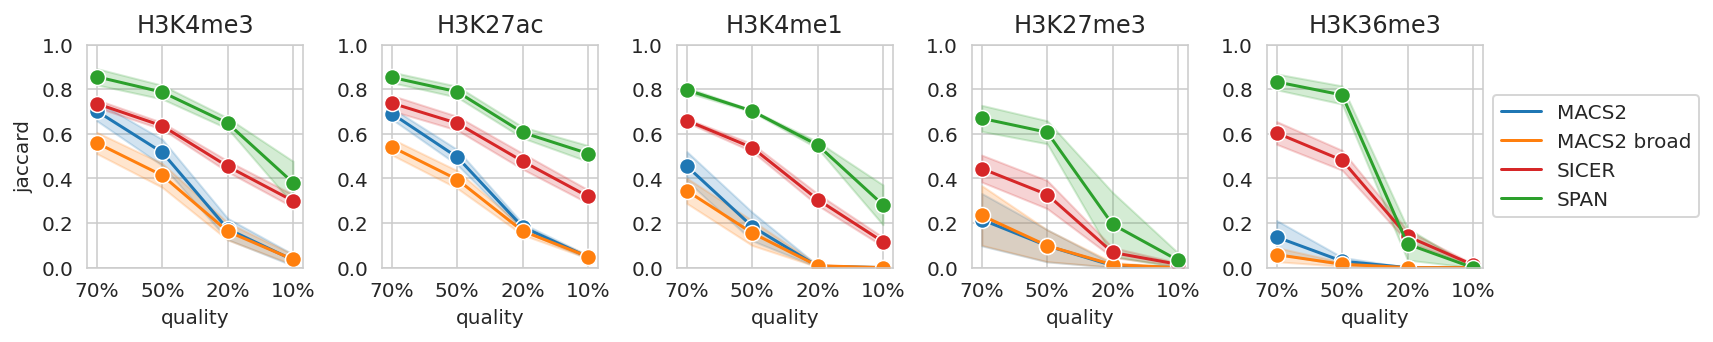

In [13]:
plt.figure(figsize=(12, 2.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    ax = axs[i]
    g_results = sns.lineplot(data=mln_bench_df_all[mln_bench_df_all['modification']==m],
                             x='q', y='jaccard', hue='name',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             ax=ax,
                             errorbar='se', marker='o', markersize=8
                             )
    g_results.axes.set_xticks(range(4), minor=False)
    # g_results.axes.set_xticklabels(['7M', '5M', '2M', '1M'])
    g_results.axes.set_xticklabels(['70%', '50%', '20%', '10%'])
    g_results.axes.set_xlabel('quality')
    g_results.axes.set_ylabel('jaccard')
    g_results.axes.title.set_text(f'{m}')
    ax.set_ylim([0, 1.0])
    # Put a legend to the right of the current axis
    if i == 4:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(GSE26320_NOISE_PATH_HG38 + f'/pics/jaccard_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [14]:
t = pd.DataFrame(data=[(m, c, r, t, 10, 1.0, -1)
                       for m, c, r, t in tqdm(product(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                                                      GSE26320_CELLS, GSE26320_REPS, TOOLS))],
                 columns=['modification', 'cell', 'replicate', 'name', 'quality', 'jaccard', 'q'])
mln_bench_df_all = pd.concat([mln_bench_df_all, t]).reset_index(drop=True)
mln_bench_df_all.sample(5)

0it [00:00, ?it/s]

,cell,replicate,name,full_peaks,full_peaks_len,quality,mln_peaks,mln_peaks_len,full_overlap,mln_overlap,overlap_len,precision,sensitivity,f1,precision_len,sensitivity_len,f1_len,jaccard,q,modification
64,Huvec,rep1,MACS2,28373.0,28242282.0,7,25738.0,24151644.0,23062.0,25650.0,24068746.0,0.996581,0.812815,0.895366,0.996568,0.852224,0.918761,0.849730,0,H3K4me3
100,GM12878,rep1,MACS2 broad,31476.0,65449208.0,7,33179.0,37521913.0,22421.0,33179.0,37519967.0,1.000000,0.712320,0.831994,0.999948,0.573268,0.728747,0.573251,0,H3K27ac
568,H1,rep2,MACS2,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-1,H3K27ac
615,K562,rep1,SPAN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-1,H3K4me1
602,HMEC,rep2,SICER,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-1,H3K4me1


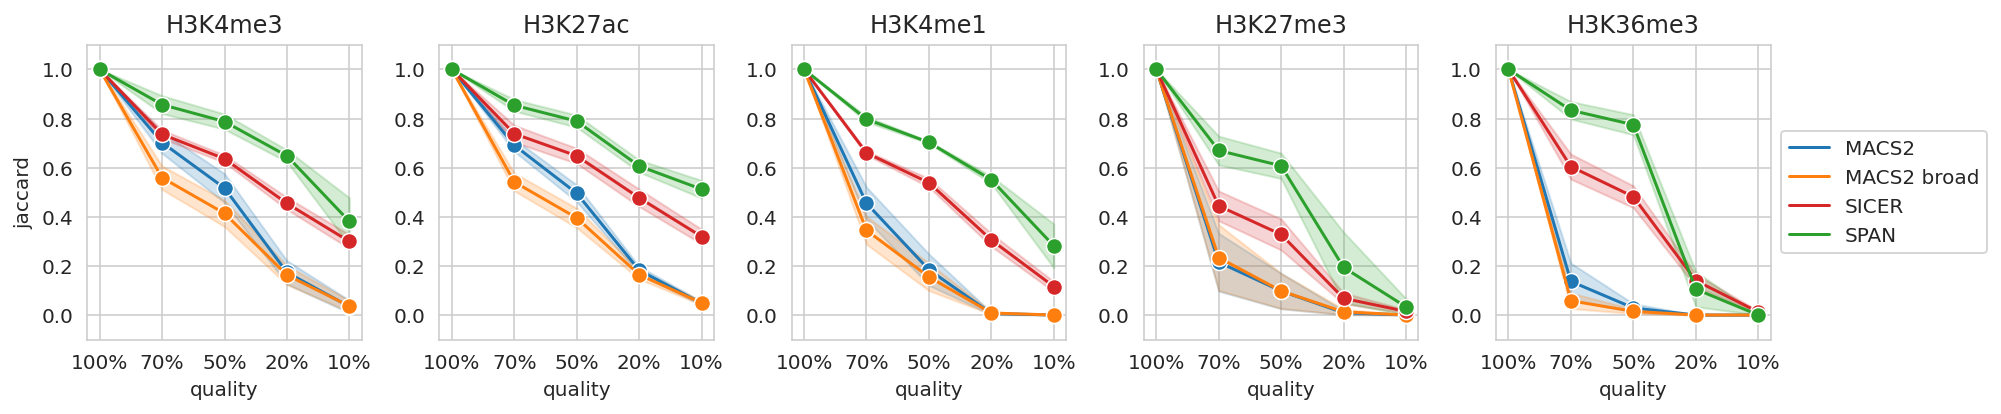

In [15]:
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    ax = axs[i]
    g_results = sns.lineplot(data=mln_bench_df_all[mln_bench_df_all['modification']==m],
                             x='q', y='jaccard', hue='name',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             ax=ax,
                             errorbar='se', marker='o', markersize=8
                             )
    g_results.axes.set_xticks([-1, 0, 1, 2, 3], minor=False)
    # g_results.axes.set_xticklabels(['5M', '2M'])
    g_results.axes.set_xticklabels(['100%', '70%', '50%', '20%', '10%'])
    g_results.axes.set_xlabel('quality')
    g_results.axes.set_ylabel('jaccard')
    g_results.axes.title.set_text(f'{m}')
    ax.set_ylim([-0.1, 1.1])
    # Put a legend to the right of the current axis
    if i == 4:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(GSE26320_NOISE_PATH_HG38 + f'/pics/jaccard_all3.pdf', bbox_inches='tight', dpi=300)
plt.show()

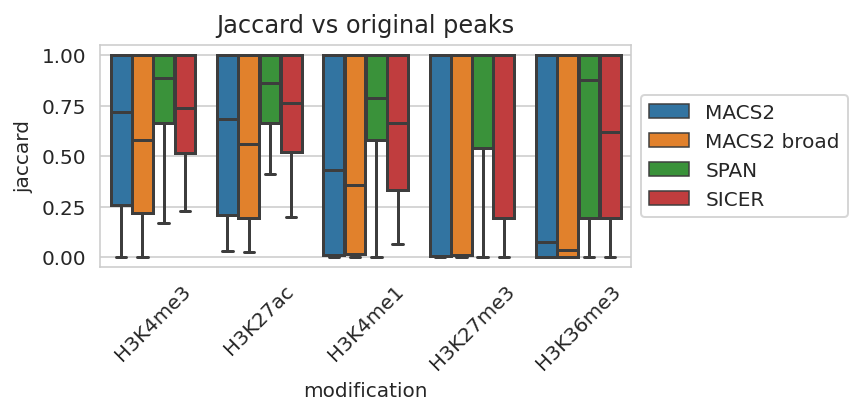

In [16]:
plt.figure(figsize=(6, 3))
g_results = sns.boxplot(data=mln_bench_df_all,
                        x='modification', y='jaccard', hue='name',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False
                        # errorbar='se', marker='o', markersize=8
                        )
ax = g_results.axes
ax.set_title('Jaccard vs original peaks')
ax.xaxis.set_tick_params(rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(GSE26320_NOISE_PATH_HG38 + f'/pics/jaccard_all2.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Jaccard AUC

In [28]:
mln_bench_df_all['quality'].unique()

array([ 7,  5,  2,  1, 10])

In [35]:
t = []
for (m, c, r, tool), dft in tqdm(mln_bench_df_all.groupby(['modification', 'cell', 'replicate', 'name'])):
    dft = dft.copy()
    dft.sort_values(by=['quality'], inplace=True)
    if len(dft) != 5:
        continue
    dft['q'] = [0.1, 0.2, 0.5, 0.7, 1.0]
    aj = 0
    qprev = 0
    jprev = 0
    for _, (q, jaccard) in dft[['q', 'jaccard']].iterrows():
        aj += (q - qprev) * (jaccard + jprev) / 2
        qprev, jprev = q, jaccard
    t.append((m, c, r, tool, aj))
dfjaccardauc = pd.DataFrame(data=t, columns=['modification', 'cell', 'replicate', 'tool', 'AUC'])
dfjaccardauc

  0%|          | 0/360 [00:00<?, ?it/s]

,modification,cell,replicate,tool,AUC
0,H3K27ac,GM12878,rep1,MACS2,0.484840
1,H3K27ac,GM12878,rep1,MACS2 broad,0.434068
2,H3K27ac,GM12878,rep1,SICER,0.647495
3,H3K27ac,GM12878,rep1,SPAN,0.741805
4,H3K27ac,GM12878,rep2,MACS2,0.482380
...,...,...,...,...,...
103,H3K4me3,K562,rep1,SPAN,0.607804
104,H3K4me3,K562,rep2,MACS2,0.483699
105,H3K4me3,K562,rep2,MACS2 broad,0.430811
106,H3K4me3,K562,rep2,SICER,0.611798


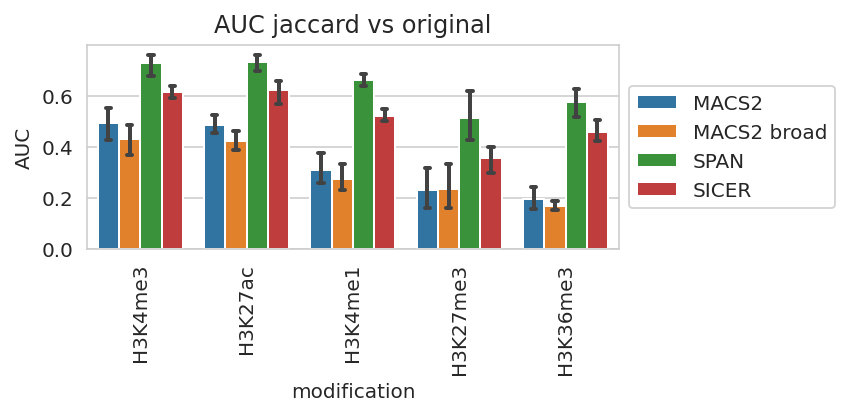

In [36]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.title.set_text('AUC jaccard vs original')
g_results = sns.barplot(data=dfjaccardauc,
                        x='modification', y='AUC',
                        hue='tool',
                        ax=ax,
                        capsize=.05, errwidth=2,
                        order=GSE26320_MODIFICATIONS,
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        )
ax.xaxis.set_tick_params(rotation=90)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Summary Jaccard replicates

In [46]:
reps_overlap_all = pd.concat([
    pd.read_csv(GSE26320_NOISE_PATH_HG38 + f'/{m}_replicates_df.csv')
    for m in ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
]).reset_index(drop=True)
reps_overlap_all.sample(5)

,modification,quality,cell,tool,rep1,rep2,peaks1,peaks1_len,peaks2,peaks2_len,peaks1_overlap,peaks2_overlap,peaks_overlap_len,diff1,diff2,jaccard,jaccardp,q
181,H3K4me1,10,H1,MACS2 broad,rep1,rep2,54953,49924070,95,61121,92,95,60638,54861,0,0.001215,0.003343,0
240,H3K27me3,10,K562,MACS2,rep1,rep2,9953,3897646,13503,2972003,926,996,183644,9027,12507,0.027467,0.079193,0
45,H3K4me3,5,K562,MACS2 broad,rep1,rep2,22922,21734937,19031,16944115,16441,16837,14269087,6481,2194,0.584560,0.791251,2
190,H3K4me1,7,GM12878,SICER,rep1,rep2,52006,150904594,48557,132294843,38913,40086,101157989,13093,8471,0.555687,0.783037,1
102,H3K27ac,10,Huvec,SICER,rep1,rep2,38747,100624853,34150,115050650,30297,29393,78989878,8450,4757,0.577895,0.821046,0


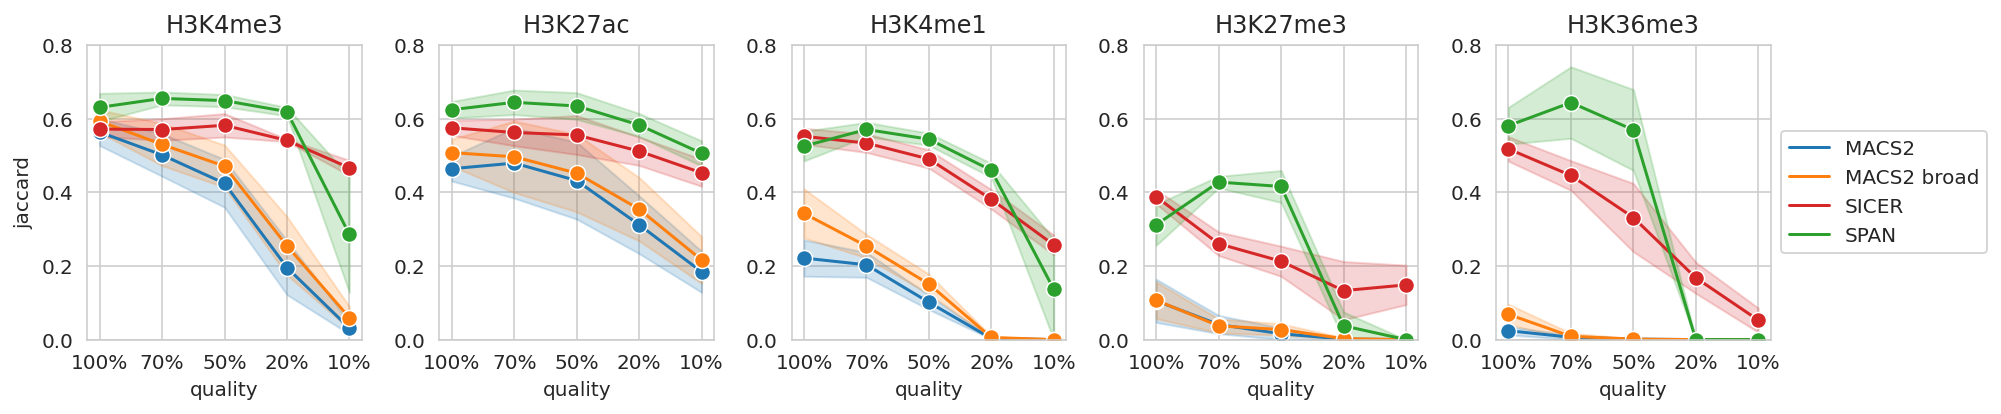

In [47]:
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    ax = axs[i]
    g_results = sns.lineplot(data=reps_overlap_all[reps_overlap_all['modification'] == m],
                             x='q', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             ax=ax,
                             errorbar='se', marker='o', markersize=8
                             )
    g_results.axes.set_xticks(range(5), minor=False)
    # g_results.axes.set_xticklabels(['Original', '7M', '5M', '2M', '1M'])
    g_results.axes.set_xticklabels(['100%', '70%', '50%', '20%', '10%'])
    g_results.axes.set_xlabel('quality')
    g_results.axes.set_ylabel('jaccard')
    g_results.axes.title.set_text(f'{m}')
    ax.set_ylim([0, .8])
    # Put a legend to the right of the current axis
    if i == 4:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)

plt.tight_layout()
plt.savefig(GSE26320_NOISE_PATH_HG38 + f'/pics/replicates_jaccard_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Jaccard AUC

In [51]:
t = []
for m, c, tool in tqdm(product(reps_overlap_all['modification'].unique(),
                                  reps_overlap_all['cell'].unique(),
                                  reps_overlap_all['tool'].unique())):
    # print(c, r, tool)
    dft = reps_overlap_all[(reps_overlap_all['modification'] == m) &
                           (reps_overlap_all['cell'] == c) &
                           (reps_overlap_all['tool'] == tool)].copy()
    if len(dft) != 5:
        continue
    dft.sort_values(by=['quality'], inplace=True)
    dft['q'] = [0.1, 0.2, 0.5, 0.7, 1.0]
    aj = 0
    qprev, jprev = 0, 0
    for _, row in dft.iterrows():
        aj += (row['q'] - qprev) * (row['jaccard'] + jprev) / 2
        qprev, jprev = row['q'], row['jaccard']
    t.append((m, c, tool, aj))
dfjaccardrepsauc = pd.DataFrame(data=t, columns=['modification', 'cell', 'tool', 'AUC'])
dfjaccardrepsauc

0it [00:00, ?it/s]

,modification,cell,tool,AUC
0,H3K4me3,GM12878,MACS2,0.293782
1,H3K4me3,GM12878,MACS2 broad,0.353594
2,H3K4me3,GM12878,SICER,0.557593
3,H3K4me3,GM12878,SPAN,0.608250
4,H3K4me3,K562,MACS2,0.448437
5,H3K4me3,K562,MACS2 broad,0.484447
6,H3K4me3,K562,SICER,0.538868
7,H3K4me3,K562,SPAN,0.596621
8,H3K4me3,Huvec,MACS2,0.326808
9,H3K4me3,Huvec,MACS2 broad,0.360166


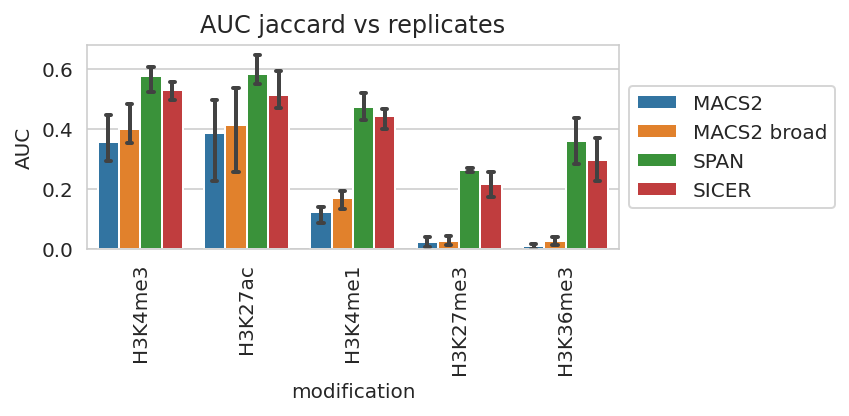

In [52]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.title.set_text('AUC jaccard vs replicates')
g_results = sns.barplot(data=dfjaccardrepsauc,
                        x='modification', y='AUC',
                        hue='tool',
                        ax=ax,
                        capsize=.05, errwidth=2,
                        order=GSE26320_MODIFICATIONS,
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        )
ax.xaxis.set_tick_params(rotation=90)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# END